* [預處理](#預處理)
* [FeatureEngineering](#FeatureEngineering)
* [Model](#Model)
* [VisualiZation](#VisualiZation)

 <a name="預處理"></a>
## 預處理


In [1]:
# 分析的主要目標為讓YouTube頻道更受歡迎，作法包含隱藏成效差的影片、定標題策略、找尋成效較好的影片類型等等
import pandas as pd #讀取所需套件
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from pylab import mpl
import warnings
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn import metrics

import warnings
pd.options.display.float_format = '{:,.4f}'.format
warnings.filterwarnings("ignore")
sns.set(rc={'figure.figsize':(9,6)})
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
sns.set(font="SimSun")
plt.style.use('ggplot')
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']  
mpl.rcParams['axes.unicode_minus'] = False
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
from IPython.display import display
%matplotlib inline
plt.style.use('ggplot')
  
raw = pd.read_excel('./raw/content.xlsx',dtype={'曝光次數':int,'影片發布時間':str,'曝光點閱率':float}) #讀取要分析的檔案
print(raw.columns)
raw.head(2)

Index(['內容', '影片標題', '縮圖', '影片發布時間', '喜歡與不喜歡人數 (%)',
       'YouTube Premium 觀看時間 (小時)', 'YouTube Premium 觀看次數', '新觀眾', '回訪的觀眾',
       '資訊卡顯示次數', '資訊卡點擊次數', '訂閱人數', '分享次數', '流失的訂閱人數', '獲得的訂閱人數', '已新增留言',
       '不喜歡的人數', '喜歡的人數', '每位觀眾的平均觀看次數', '非重複觀眾人數', '平均觀看比例 (%)', '觀看次數',
       '觀看時間 (小時)', '平均觀看時長', '曝光次數', '曝光點閱率 (%)'],
      dtype='object')


,內容,影片標題,縮圖,影片發布時間,喜歡與不喜歡人數 (%),YouTube Premium 觀看時間 (小時),YouTube Premium 觀看次數,新觀眾,回訪的觀眾,資訊卡顯示次數,...,不喜歡的人數,喜歡的人數,每位觀眾的平均觀看次數,非重複觀眾人數,平均觀看比例 (%),觀看次數,觀看時間 (小時),平均觀看時長,曝光次數,曝光點閱率 (%)
0,j6jCfVrYFxQ,【拯救公主】【忍豆風雲2 重製II】【公測】 #懷舊系列 #私服,0.0000,NaN,NaN,0.0000,0.0000,NaN,NaN,0.0000,...,0.0000,0.0000,NaN,NaN,79.5400,2.0000,0.0212,0:00:38,0,NaN
1,h0nm7QoocJc,AI test,0.0000,NaN,NaN,0.1149,3.0000,NaN,NaN,0.0000,...,0.0000,0.0000,NaN,NaN,56.8500,15.0000,0.3245,0:01:17,0,NaN


In [2]:
#對檔案做些預處理，以便後續分析
df = raw.copy()
df = df.drop(index=0) #排除總計欄
df = df.dropna(axis=1, how='all') #排除全部都是na的欄

df = df.fillna('0')
df = df[df.內容 != '總計']
df = df[df.影片發布時間 != '0'] #排除不公開的影片
df = df[df.平均觀看時長 != '0'] #排除不公開的影片


dint = [ 'YouTube Premium 觀看時間 (小時)',
       'YouTube Premium 觀看次數', '回訪的觀眾', '新觀眾', '資訊卡顯示次數', '資訊卡點擊次數', '訂閱人數',
       '分享次數', '流失的訂閱人數', '獲得的訂閱人數', '已新增留言', '不喜歡的人數', '喜歡的人數', '每位觀眾的平均觀看次數',
       '非重複觀眾人數', '平均觀看比例 (%)', '觀看次數', '觀看時間 (小時)', '曝光次數','曝光點閱率 (%)']
df[dint] = df[dint].astype(float)

df = df.rename(columns={'曝光點閱率 (%)':'曝光點閱率', '平均觀看比例 (%)':'平均觀看比例',
                    '影片發布時間':'date', '觀看時間 (小時)':'觀看小時'})



df['曝光點閱率'] = df['曝光點閱率']/100 #曝光點擊率換成小數點，後面比較好分析

df['平均觀看比例'] = df['平均觀看比例']/100
# df['profit'] = df['YouTube 廣告收益 (TWD)']+df['您的 YouTube Premium 收益 (TWD)']+df['您的交易收益 (TWD)'] #把三種收益相加(profit)，分開計算感覺意義不大
# df = df.drop(columns={'YouTube 廣告收益 (TWD)','您的 YouTube Premium 收益 (TWD)'}) #移除原本的收益欄位
df['訂閱比例'] = df['獲得的訂閱人數']/(df['獲得的訂閱人數']+df['流失的訂閱人數'])

df['date2'] = pd.to_datetime(df['date'])
df['quarter'] = pd.PeriodIndex(df.date2, freq='Q')
df['month'] = df['date2'].dt.strftime('%Y-%m')



#計算影片時長
df['minute'] = df['平均觀看時長'].str[2:4]
df['second'] = df['平均觀看時長'].str[5:7]
df['minute'] = df['minute'].astype(int)
df['second'] = df['second'].astype(int)
df['觀看秒數'] = df['second']+df['minute']*60 #先把平均觀看比例轉換為分(欄位viewmins)，以便後續計算

#把平均觀看秒數除以觀看比例，得出影片時長，影片時長的誤差約在三秒內，應該是由於原始檔的平均觀看秒數只給到小數點兩位
df['影片秒數'] = df['觀看秒數']/df['平均觀看比例']
df = df.drop(columns={'minute','second'})

df = df.reset_index(drop=1)

#幾乎沒用到資訊卡和片尾元素，所以排除，短片資料異常，有短片可是全為0，也先排除
# df = df.drop(columns=['資訊卡前導廣告每次顯示所獲得的點擊次數 (%)','資訊卡前導廣告顯示次數','資訊卡前導文字點擊次數',
#                   '資訊卡每次顯示所獲得的點擊次數 (%)','資訊卡顯示次數','資訊卡點擊次數','片尾元素顯示次數','片尾元素點擊次數',
#                   '短片的影片觀看時間 (小時)','短片觀看次數'])

# 觀看比例跟影片時長有高度負相關(影片越長越難看完)，因此把觀看比例做些處理，以便看出某部影片觀看比例的成效

pd.options.display.float_format = '{:,.2f}'.format
def f平均觀看比例(q,w,e): #我把每種時間間隔都分到超過30部影片，取平均較有意義
    rate = q
    rate2 = w
    for i in range(e):
        print(str(i*rate+rate2)+'到'+str((i*rate)+rate+rate2)+'秒的影片的平均觀看比例為',
            np.round(df[(df['影片秒數']<=(i*rate)+rate+rate2) & (df['影片秒數']>i*rate+rate2)]['平均觀看比例'].mean(),decimals=4),'，有',
            df[(df['影片秒數']<=(i*rate)+rate+rate2) & (df['影片秒數']>i*rate+rate2)]['平均觀看比例'].shape[0],'部')
        
        watchRate = pd.DataFrame({
            '影片秒數':[str(i*rate+rate2)+'到'+str((i*rate)+rate+rate2)+'秒'],
            '平均觀看比例':[df[(df['影片秒數']<=(i*rate)+rate+rate2) & (df['影片秒數']>i*rate+rate2)]['平均觀看比例'].mean()],
            '影片數':[df[(df['影片秒數']<=(i*rate)+rate+rate2) & (df['影片秒數']>i*rate+rate2)]['平均觀看比例'].shape[0]],
            '起始時間':[str(i*rate+rate2)]
            })
        watchRate.to_csv('watchRate.csv',mode='a',index=0,encoding='utf-8-sig')

f平均觀看比例(180,0,2)        
f平均觀看比例(300,360,1)
f平均觀看比例(9999,660,1)
watchRate = pd.read_csv('watchRate.csv')
watchRate = watchRate[watchRate['影片秒數'] != '影片秒數']
watchRate['平均觀看比例'] = watchRate['平均觀看比例'].astype(float)
watchRate = watchRate.drop_duplicates()
watchRate = watchRate.reset_index(drop=1)
watchRate['平均觀看比例'] = np.round_(list(watchRate['平均觀看比例']), decimals = 4) 
watchRate

conditions=[df['影片秒數']<=int(watchRate.起始時間[1]), df['影片秒數']<=int(watchRate.起始時間[2]),
            df['影片秒數']<=int(watchRate.起始時間[3]), df['影片秒數']>int(watchRate.起始時間[3])]
values=watchRate['平均觀看比例']
df['平均觀看比例2'] = np.select(conditions,values)
df['平均觀看比例2'] = df.平均觀看比例2.astype(float)
df['平均觀看比例3'] = df['平均觀看比例']-df['平均觀看比例2'] 
print('平均觀看比例3: ', df.平均觀看比例3.mean()) #-0.00115，非常小的負數，表示處理過後的觀看比例，可以當成大於0成效較高，小於0成效較差
df.shape

0到180秒的影片的平均觀看比例為 0.4545 ，有 42 部
180到360秒的影片的平均觀看比例為 0.3508 ，有 49 部
360到660秒的影片的平均觀看比例為 0.2601 ，有 29 部
660到10659秒的影片的平均觀看比例為 0.1689 ，有 28 部
平均觀看比例3:  1.3513513513509024e-05


(148, 34)

In [3]:
df.columns

Index(['內容', '影片標題', '縮圖', 'date', '喜歡與不喜歡人數 (%)', 'YouTube Premium 觀看時間 (小時)',
       'YouTube Premium 觀看次數', '新觀眾', '回訪的觀眾', '資訊卡顯示次數', '資訊卡點擊次數', '訂閱人數',
       '分享次數', '流失的訂閱人數', '獲得的訂閱人數', '已新增留言', '不喜歡的人數', '喜歡的人數', '每位觀眾的平均觀看次數',
       '非重複觀眾人數', '平均觀看比例', '觀看次數', '觀看小時', '平均觀看時長', '曝光次數', '曝光點閱率', '訂閱比例',
       'date2', 'quarter', 'month', '觀看秒數', '影片秒數', '平均觀看比例2', '平均觀看比例3'],
      dtype='object')

In [4]:
df['喜歡與不喜歡人數 (%)']=df['喜歡與不喜歡人數 (%)'].astype(float) #喜歡與不喜歡人數 (%)應該要是小數
df.select_dtypes(include=('object')).head(2)

,內容,影片標題,縮圖,date,平均觀看時長,month
0,sSfuLmNlKZY,MC地獄圖BUG,0.00,"Jul 9, 2022",0:00:32,2022-07
1,yPrhQk0XdAk,2022 07 30 23 12 27,0.00,"Aug 1, 2022",0:00:09,2022-08


In [5]:
df['date'] = pd.to_datetime(df['date']) 

In [6]:
df.isna().sum().reset_index().style.highlight_min() #查找是否有欄位有NA

,index,0
0,內容,0
1,影片標題,0
2,縮圖,0
3,date,0
4,喜歡與不喜歡人數 (%),0
5,YouTube Premium 觀看時間 (小時),0
6,YouTube Premium 觀看次數,0
7,新觀眾,0
8,回訪的觀眾,0
9,資訊卡顯示次數,0


In [7]:
df = df.fillna(0.0, axis=0) #NA取代為0
df.isna().sum().sum() 
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]  #排除不公開的影片
df.shape

(148, 34)

In [8]:
df.回訪的觀眾.mean()

0.0

In [9]:
# 其他欄位與曝光點閱率的相關係數
expoRate=df.corr()['曝光點閱率'].sort_values(ascending=False).reset_index()[1:]
df.corr()['曝光點閱率'].sort_values(ascending=False).reset_index()[1:].style.bar(align='mid')

,index,曝光點閱率
1,獲得的訂閱人數,0.215031
2,觀看次數,0.211156
3,YouTube Premium 觀看次數,0.210695
4,訂閱人數,0.207058
5,觀看小時,0.191778
6,訂閱比例,0.185477
7,YouTube Premium 觀看時間 (小時),0.172557
8,分享次數,0.171410
9,已新增留言,0.153818
10,喜歡的人數,0.152044


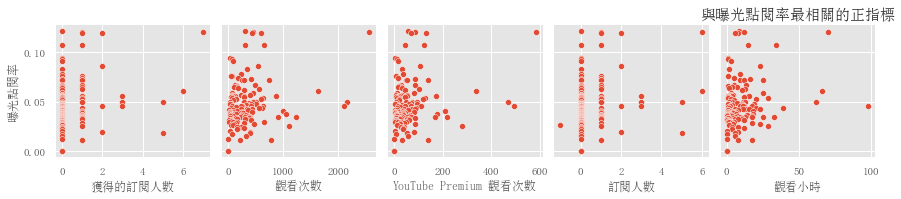

In [10]:
topCorrName = df.corr()['曝光點閱率'].sort_values(ascending=False).reset_index()['index'][:6].values
sns.pairplot(df[topCorrName], x_vars=topCorrName[1:], y_vars=topCorrName[0])
plt.title('與曝光點閱率最相關的正指標', fontsize=15) #觀看小時為總觀看時長(小時)
plt.show()

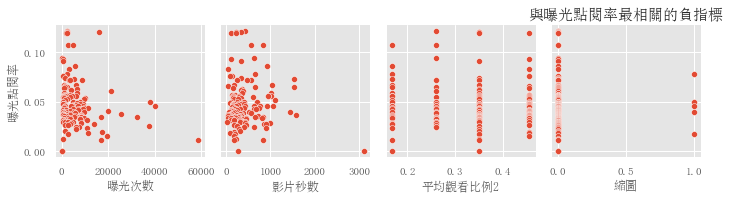

In [11]:
topCorrName = df.corr()['曝光點閱率'].sort_values(ascending=True).reset_index()['index'].values
sns.pairplot(df[topCorrName], x_vars=topCorrName[0:4], y_vars=['曝光點閱率'])
plt.title('與曝光點閱率最相關的負指標', fontsize=15) #觀看小時為總觀看時長(小時)
plt.show()

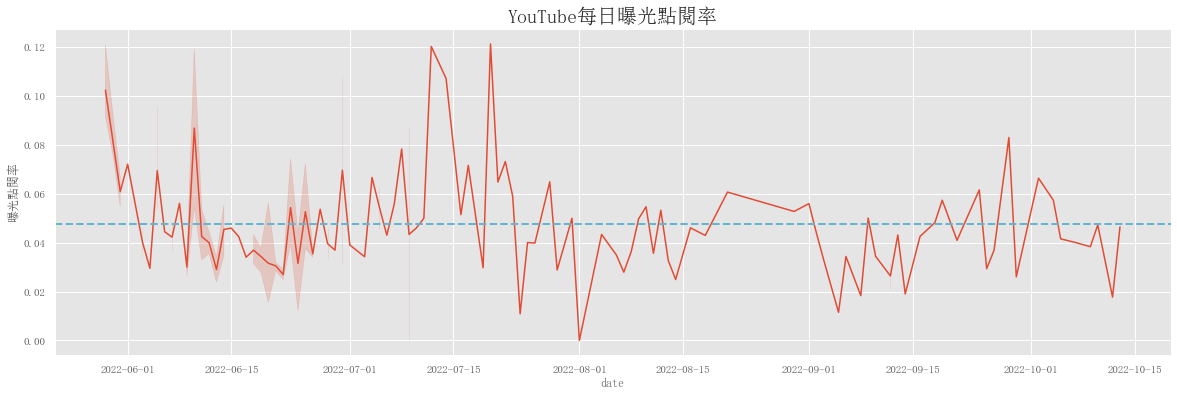

0.047375


In [12]:
plt.figure(figsize=(20, 6))
sns.lineplot(data=df, x='date', y='曝光點閱率')
plt.axhline(df.曝光點閱率.mean(), color='c', linestyle='--', linewidth=2)
plt.annotate('平均曝光點閱率 {}'.format(round(df.曝光點閱率.mean(),4)), 
             (df.date[20], 30), 
             fontsize=12, 
             color='c')
plt.title('YouTube每日曝光點閱率', fontsize=20)
plt.ylabel('曝光點閱率')
plt.show()
print(df.曝光點閱率.mean())

In [13]:
# df=df[~df.影片標題.str.contains('與忍3的差異')]

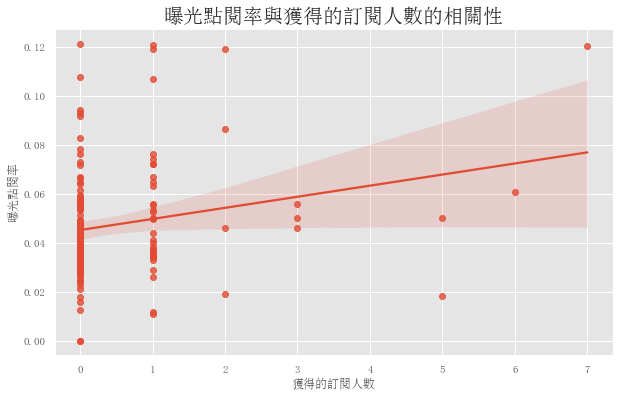

In [14]:
plt.figure(figsize=(10,6))
sns.regplot(data=df, x='獲得的訂閱人數', y='曝光點閱率')
plt.title('曝光點閱率與獲得的訂閱人數的相關性', fontsize=20)
plt.show()

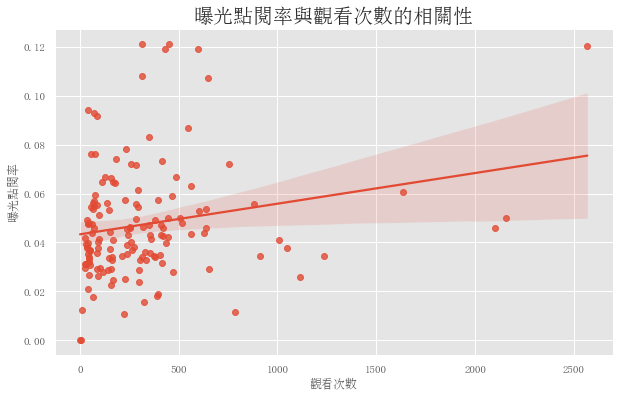

In [15]:
plt.figure(figsize=(10,6))
sns.regplot(data=df, x='觀看次數', y='曝光點閱率')
plt.title('曝光點閱率與觀看次數的相關性', fontsize=20)
plt.show()

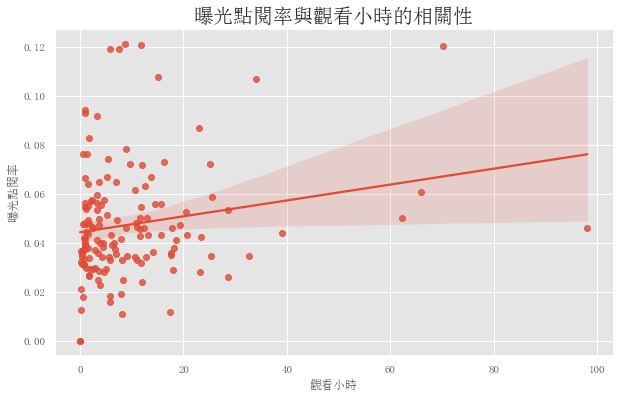

In [16]:
plt.figure(figsize=(10,6))
sns.regplot(data=df, x='觀看小時', y='曝光點閱率')
plt.title('曝光點閱率與觀看小時的相關性', fontsize=20)
plt.show()

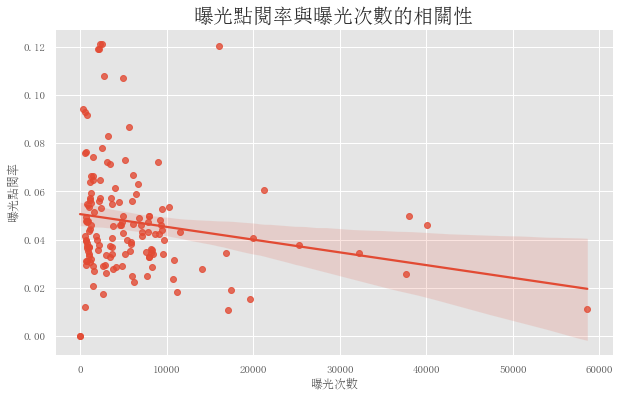

In [17]:
# 曝光次數 ≠ 觀看次數 / 曝光點閱率
# 因為沒曝光也可能有觀看，比如說貼影片網址到群組，有人點進去就會變成沒曝光有觀看
plt.figure(figsize=(10,6))
sns.regplot(data=df, x='曝光次數', y='曝光點閱率')
plt.title('曝光點閱率與曝光次數的相關性', fontsize=20)
plt.show()

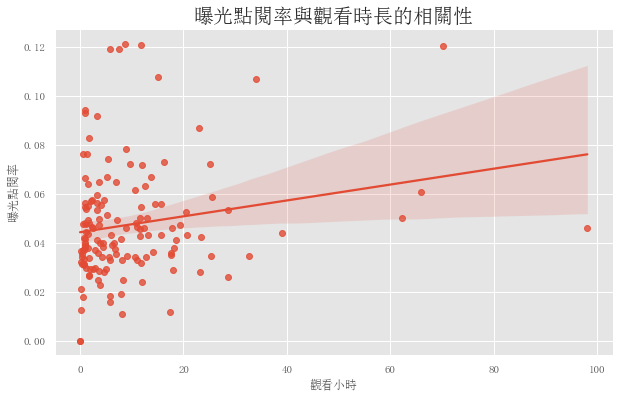

In [18]:
plt.figure(figsize=(10,6))
sns.regplot(data=df, x='觀看小時', y='曝光點閱率')
plt.title('曝光點閱率與觀看時長的相關性', fontsize=20)
plt.show()

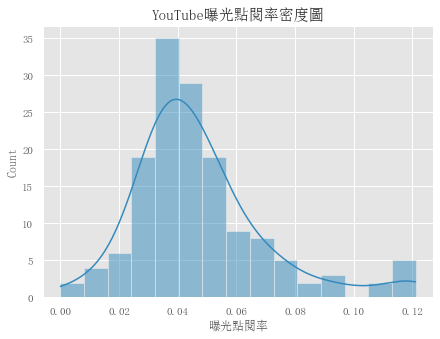

In [19]:
plt.figure(figsize=(7,5))
sns.histplot(df['曝光點閱率'], kde=True)
plt.title('YouTube曝光點閱率密度圖', fontsize=15)
# plt.xlabel('曝光點閱率')
plt.show()

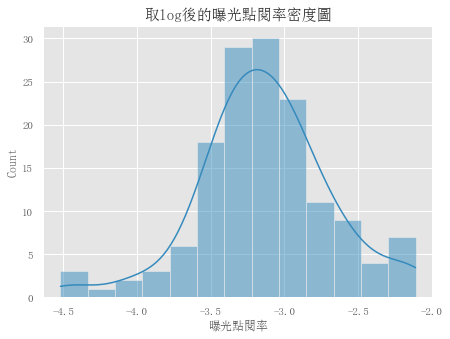

In [20]:
plt.figure(figsize=(7,5))
sns.histplot(np.log(df['曝光點閱率']), kde=True)
plt.title('取log後的曝光點閱率密度圖', fontsize=15)
# plt.xlabel('取log後的曝光點閱率密度圖') #因為資料右偏所以取log
plt.show()

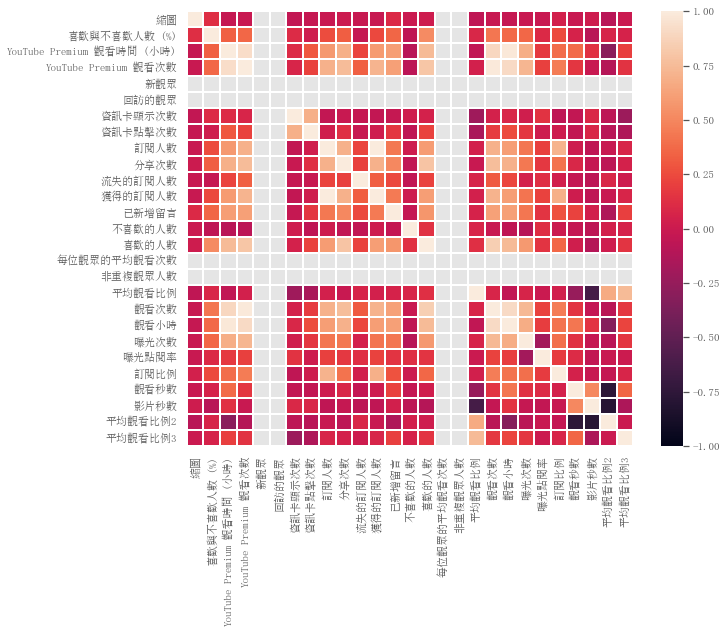

In [21]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), vmin=-1, vmax=1, linewidths=.2) #熱點圖heatmap
plt.show()

In [22]:
df.describe().loc[['mean', 'std', 'min', '50%', 'max']]

,縮圖,喜歡與不喜歡人數 (%),YouTube Premium 觀看時間 (小時),YouTube Premium 觀看次數,新觀眾,回訪的觀眾,資訊卡顯示次數,資訊卡點擊次數,訂閱人數,分享次數,...,平均觀看比例,觀看次數,觀看小時,曝光次數,曝光點閱率,訂閱比例,觀看秒數,影片秒數,平均觀看比例2,平均觀看比例3
mean,0.03,60.86,1.87,58.91,0.00,0.00,0.07,0.02,0.48,1.32,...,0.33,323.37,9.66,"6,136.15",0.05,0.30,98.28,416.21,0.33,0.00
std,0.18,45.66,3.05,84.37,0.00,0.00,0.33,0.14,1.06,2.65,...,0.15,387.94,13.60,"8,261.23",0.02,0.46,48.66,394.44,0.10,0.11
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,9.00,19.44,0.17,-0.29
50%,0.00,100.00,0.96,36.50,0.00,0.00,0.00,0.00,0.00,0.00,...,0.30,238.50,5.35,"3,667.00",0.04,0.00,95.00,300.36,0.35,-0.00
max,1.00,100.00,24.24,582.00,0.00,0.00,3.00,1.00,6.00,18.00,...,0.72,"2,569.00",98.12,"58,625.00",0.12,1.00,223.00,"3,103.45",0.45,0.26


 <a name="FeatureEngineering"></a>
## FeatureEngineering

In [23]:
Subs = df.訂閱人數.values.tolist()
Subs_accumulated = []
count = 0
for s in Subs:
    count += s
    Subs_accumulated.append(count)
df=df.sort_values(by='date')    
df['Subs_accumulated'] = Subs_accumulated #日期累積訂閱數
df.head(2)

,內容,影片標題,縮圖,date,喜歡與不喜歡人數 (%),YouTube Premium 觀看時間 (小時),YouTube Premium 觀看次數,新觀眾,回訪的觀眾,資訊卡顯示次數,...,曝光點閱率,訂閱比例,date2,quarter,month,觀看秒數,影片秒數,平均觀看比例2,平均觀看比例3,Subs_accumulated
3,5rnLJjh-n78,櫻花林初體驗【忍豆風雲2 重製II 私服】【千人斬】【櫻花林一】#懷舊系列,0.00,2022-05-29,0.00,1.88,87.00,0.00,0.00,0.00,...,0.12,1.00,2022-05-29,2022Q2,2022-05,94,331.92,0.35,-0.07,0.00
9,5N-XwiAyu9A,練忍走ㄉ日常【忍豆風雲2 重製II 私服】【其他】#懷舊系列,0.00,2022-05-29,0.00,0.05,5.00,0.00,0.00,0.00,...,0.09,0.00,2022-05-29,2022Q2,2022-05,75,625.00,0.26,-0.14,0.00


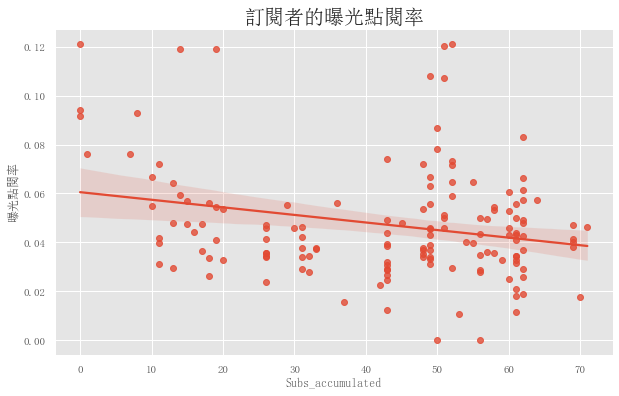

In [24]:
plt.figure(figsize=(10,6))
sns.regplot(data=df, x='Subs_accumulated', y='曝光點閱率')
plt.title('訂閱者的曝光點閱率', fontsize=20)
plt.show()

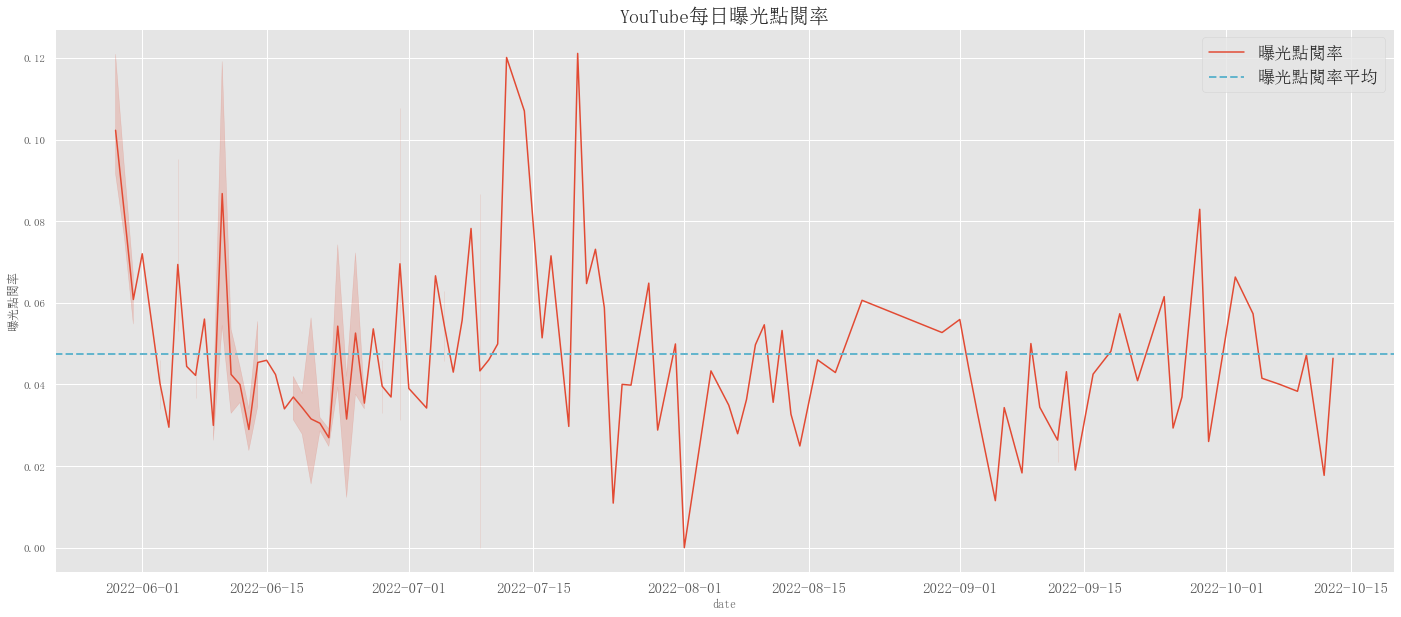

In [25]:
f, ax = plt.subplots(1, 1, figsize=(24, 10))

ax = sns.lineplot(data=df, x='date', y='曝光點閱率', label='曝光點閱率', lw=1.5)

plt.axhline(df.曝光點閱率.mean(), color='c', linestyle='--', linewidth=2, label='曝光點閱率平均')

plt.title('YouTube每日曝光點閱率', fontsize=20)
plt.ylabel('曝光點閱率')
plt.xticks(fontsize=15)
ax.legend(fontsize='xx-large')
plt.show()

### Check Variance Inflation Factor for Colinearity

In [26]:
from sklearn.linear_model import LinearRegression

def calculate_vif(df, features):    
    vif, tolerance = {}, {}
    # all the features that you want to examine
    for feature in features:
        # extract all the other features you will regress against
        X = [f for f in features if f != feature]        
        X, y = df[X], df[feature]
        # extract r-squared from the fit
        r2 = LinearRegression().fit(X, y).score(X, y)                
        
        # calculate tolerance
        tolerance[feature] = 1 - r2
        # calculate VIF
        vif[feature] = 1/(tolerance[feature])
    # return VIF DataFrame
    return pd.DataFrame({'VIF': vif, 'Tolerance': tolerance})

cell_hover = {  # for row hover use <tr> instead of <td>
    'selector': 'td:hover',
    'props': [('background-color', 'green')]
}

# df.corr()['觀看次數'].sort_values(ascending=False).reset_index().style.set_table_styles([cell_hover])

In [27]:
df.corr()['曝光點閱率'].sort_values(ascending=False).reset_index()['index'][1:].values

array(['獲得的訂閱人數', '觀看次數', 'YouTube Premium 觀看次數', '訂閱人數', '觀看小時', '訂閱比例',
       'YouTube Premium 觀看時間 (小時)', '分享次數', '已新增留言', '喜歡的人數', '資訊卡顯示次數',
       '流失的訂閱人數', '不喜歡的人數', '觀看秒數', '喜歡與不喜歡人數 (%)', '資訊卡點擊次數', '平均觀看比例3',
       '平均觀看比例', '縮圖', '平均觀看比例2', '影片秒數', '曝光次數', 'Subs_accumulated',
       '新觀眾', '回訪的觀眾', '每位觀眾的平均觀看次數', '非重複觀眾人數'], dtype=object)

In [28]:
features_chosen=[
                 '觀看小時', 
                 'Unique_viewers', 
                 'Views', 
                 '喜歡的人數', 
                 '不喜歡的人數',
                 'Impressions', 
                 'Subs_accumulated',
                 'Subscribers', 
                 '已新增留言', 
                 '分享次數',
                 'Videos',
                 '觀看秒數', 
                 'Average_views_per_viewer', 
                 '平均觀看比例',
                 '曝光點閱率'
                 ]
d2=df.drop(columns=['date','平均觀看時長','date2','quarter','month','內容','影片標題'])

# http://www.gotop.com.tw/epaper/e0719/AEM000900n.pdf
# 查看容忍值(tolerance)，容忍值 = (1- 自變數被其它變數所解釋的變異量)，
# 容忍值( 0~1 之間)，愈大愈好，容忍值愈大，代表共線性問題愈小，容忍值
# 的倒數 = 變異數膨脹因素 (VIF, variance inflation faction)，VIF 的值愈小愈
# 好，代表愈没有共線性問題。
# 當發生共線性問題時，我們可以採用 1.忽略高相關變數、2.只作預測，不作解釋
# 迴歸係數、3.用來了解關係、4.使用其它迴歸分析，來處理共線性的問題。


calculate_vif(df.iloc[:,1:], features=d2.columns).style.apply(lambda x: ['background:green' if v > 0.2 else '' for v in x], axis=1)
# calculate_vif(df.iloc[:,1:], features=features_chosen).style.apply(lambda x: ['background:green' if v < 0.2 else '' for v in x], axis=1)

,VIF,Tolerance
縮圖,1.136734,0.879713
喜歡與不喜歡人數 (%),2.178889,0.458950
YouTube Premium 觀看時間 (小時),71.955572,0.013897
YouTube Premium 觀看次數,108.699851,0.009200
新觀眾,inf,0.000000
回訪的觀眾,inf,0.000000
資訊卡顯示次數,2.435687,0.410562
資訊卡點擊次數,2.842301,0.351828
訂閱人數,inf,0.000000
分享次數,4.472881,0.223570


In [29]:
df.to_csv('1.csv',encoding='utf-8-sig')

In [30]:
cols=['曝光點閱率',
    # '獲得的訂閱人數',
 '觀看次數',
#  'YouTube Premium 觀看次數',
 '訂閱人數',
 '觀看小時',
#  '訂閱比例',
#  'YouTube Premium 觀看時間 (小時)',
 '分享次數',
 '已新增留言',
 '喜歡的人數',
 '資訊卡顯示次數',
#  '流失的訂閱人數',
 '不喜歡的人數',
 '觀看秒數',
 '喜歡與不喜歡人數 (%)',
#  '資訊卡點擊次數',
 '平均觀看比例',
#  '縮圖',
#  '影片秒數',
 '曝光次數']

d_new = d2.copy()
d_new=d_new[d_new.觀看小時!=2.4263]
d_new=d_new[cols]

# d_new = d_new.drop(cols_remove, axis=1)
print('New Data Shape: ', d_new.shape)
d_new.head(2)

New Data Shape:  (147, 13)


,曝光點閱率,觀看次數,訂閱人數,觀看小時,分享次數,已新增留言,喜歡的人數,資訊卡顯示次數,不喜歡的人數,觀看秒數,喜歡與不喜歡人數 (%),平均觀看比例,曝光次數
3,0.12,453.00,1.00,11.83,0.00,2.00,0.00,0.00,0.00,94,0.00,0.28,"2,489.00"
9,0.09,41.00,0.00,0.86,0.00,0.00,0.00,0.00,0.00,75,0.00,0.12,318.00


In [31]:
d_new.corr()['曝光點閱率']

曝光點閱率           1.00
觀看次數            0.22
訂閱人數            0.21
觀看小時            0.19
分享次數            0.17
已新增留言           0.15
喜歡的人數           0.18
資訊卡顯示次數         0.14
不喜歡的人數          0.16
觀看秒數            0.10
喜歡與不喜歡人數 (%)    0.10
平均觀看比例          0.01
曝光次數           -0.19
Name: 曝光點閱率, dtype: float64

In [32]:
d_new.shape

(147, 13)

In [33]:
d_new.iloc[0:5,0:5]

,曝光點閱率,觀看次數,訂閱人數,觀看小時,分享次數
3,0.12,453.00,1.00,11.83,0.00
9,0.09,41.00,0.00,0.86,0.00
11,0.09,88.00,0.00,3.28,0.00
16,0.08,58.00,0.00,0.66,1.00
15,0.08,76.00,1.00,1.27,0.00


In [34]:
# # penguins = sns.load_dataset("penguins")
# sns.pairplot(d_new.iloc[:,0:7])

In [35]:
# # penguins = sns.load_dataset("penguins")
# sns.pairplot(d_new.iloc[:,3:10])

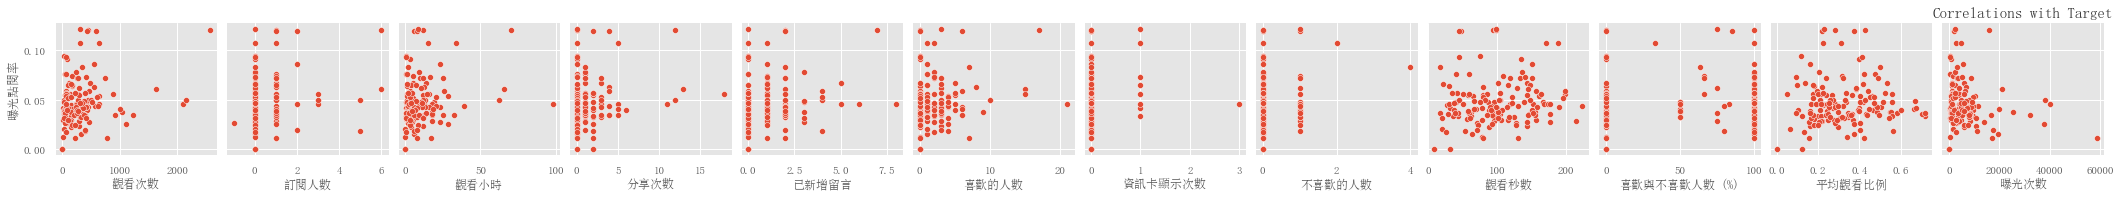

In [36]:
sns.pairplot(d_new, x_vars=d_new.columns.drop('曝光點閱率'), y_vars=['曝光點閱率'])
plt.title('Correlations with Target', fontsize=15)
plt.show()

In [37]:
#Split Data
from sklearn.model_selection import train_test_split
train = d_new[:int(len(d_new)*0.8)]
test = d_new[int(len(d_new)*0.8):]
train.shape, test.shape

((117, 13), (30, 13))

In [38]:
target = '曝光點閱率'

X_train = train.drop(target, axis=1)
y_train = train[target]
X_test = test.drop(target, axis=1)
y_test = test[target]

X_train.shape, y_train.shape

((117, 12), (117,))

In [39]:
#F-statistic & P-Values #P值越小，X和Y的相關性越高
#所以欄位P值都小於0.01，有顯著相關
from sklearn.feature_selection import f_regression
pvalue_table = (
pd.DataFrame(f_regression(X_train, y_train), columns=X_train.columns).T.rename(columns={0:'F_statistic', 1:'p_values'}))
pvalue_table.style.apply(lambda x: ["background: green" if v < 0.05 else "" for v in x], axis = 1)

,F_statistic,p_values
觀看次數,8.887520,0.003505
訂閱人數,12.914304,0.000481
觀看小時,5.895044,0.016734
分享次數,5.899503,0.016694
已新增留言,4.901752,0.028802
喜歡的人數,5.724432,0.018350
資訊卡顯示次數,2.215008,0.139411
不喜歡的人數,1.973988,0.162721
觀看秒數,0.993344,0.321019
喜歡與不喜歡人數 (%),3.795328,0.053832


 <a name="Model"></a>
## Model

In [40]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def evaluate(影片標題, y, y_):
    mae = mean_absolute_error(y, y_)
    rmse = mean_squared_error(y, y_)**0.5
    r2 = r2_score(y, y_)
    print('*{} Result*'.format(影片標題))
    # print('='*50)
    # print('MAE Score: ', mae)
    print('RMSE Score: ', round(rmse,3))
    print('R2 Score: ', round(r2,3))
    # print()
    
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
pipe_lin = make_pipeline(
    StandardScaler(),
    LinearRegression(n_jobs=-1)
)

X_train=X_train.reset_index(drop=1)
y_train=y_train.reset_index(drop=1)

pipe_lin.fit(X_train, y_train)
y_pred = np.exp(pipe_lin.predict(X_test))
# evaluate('Linear Regression', y_test, y_pred) #linear regression(會跑出無限大，無法預測，所以先不使用)

In [41]:
#Log Transformed Linear Regression
from sklearn.compose import TransformedTargetRegressor
tt_lin = TransformedTargetRegressor(regressor=pipe_lin,
                                func=np.log1p, inverse_func=np.expm1)

tt_lin.fit(X_train, y_train)
y_pred = tt_lin.predict(X_test)
evaluate('Log Transformed Linear Regression', y_test, y_pred)

*Log Transformed Linear Regression Result*
RMSE Score:  0.026
R2 Score:  -1.826


In [42]:
#Model Selection Ridge
pipe_ridge = make_pipeline(
    StandardScaler(),
    RidgeCV(alphas=np.arange(100, 105, 0.01), cv=5)
)

tt_ridge = TransformedTargetRegressor(regressor=pipe_ridge,
                                func=np.log1p, inverse_func=np.expm1)

tt_ridge.fit(X_train, y_train)
y_pred = tt_ridge.predict(X_test)
print('Best alpha: ', tt_ridge.regressor_.named_steps['ridgecv'].alpha_)
evaluate('Log Transformed Ridge', y_test, y_pred)

Best alpha:  100.0
*Log Transformed Ridge Result*
RMSE Score:  0.016
R2 Score:  -0.004


In [43]:
#Lasso
pipe_lasso = make_pipeline(
    StandardScaler(),
    LassoCV(alphas=np.arange(0, 0.2, 0.001), cv=5, random_state=33)
)

tt_lasso = TransformedTargetRegressor(regressor=pipe_lasso,
                                func=np.log1p, inverse_func=np.expm1)

tt_lasso.fit(X_train, y_train)
y_pred = tt_lasso.predict(X_test)
print('Best alpha: ', tt_lasso.regressor_.named_steps['lassocv'].alpha_)
evaluate('Log Transformed Lasso', y_test, y_pred)

Best alpha:  0.001
*Log Transformed Lasso Result*
RMSE Score:  0.02
R2 Score:  -0.571


In [44]:
#ElasticNet
from sklearn.linear_model import ElasticNetCV
pipe_elnet = make_pipeline(
    StandardScaler(),
    ElasticNetCV(n_jobs=-1, cv=5, random_state=33)
)

tt_elnet = TransformedTargetRegressor(regressor=pipe_elnet,
                                func=np.log1p, inverse_func=np.expm1)

tt_elnet.fit(X_train, y_train)
y_pred = tt_elnet.predict(X_test)
evaluate('Log Transformed ElasticNet', y_test, y_pred)

*Log Transformed ElasticNet Result*
RMSE Score:  0.023
R2 Score:  -1.12


 <a name="RF"></a>
## RF

In [45]:
#RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
pipe_rfreg = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=33)
)
tt_rfreg = TransformedTargetRegressor(regressor=pipe_rfreg,
                                func=np.log1p, inverse_func=np.expm1)
tt_rfreg.fit(X_train, y_train)
y_pred = tt_rfreg.predict(X_test)
# evaluate('Log Transformed RandomForest Regressor', y_test, y_pred)
print(evaluate('RF', y_test, y_pred))

#XGBRegressor
from xgboost import XGBRegressor
pipe_xgb = make_pipeline(
    StandardScaler(),
    XGBRegressor(learning_rate=0.1,
                  n_estimators=500,
                  n_jobs=-1,
                  random_state=33)
)

tt_xgb = TransformedTargetRegressor(regressor=pipe_xgb,
                                func=np.log1p, inverse_func=np.expm1)

tt_xgb.fit(X_train, y_train)
y_pred = tt_xgb.predict(X_test)
# print(evaluate('Log Transformed XGB Regressor', y_test, y_pred))
print(evaluate('XGB', y_test, y_pred))

#Light Gradient Boost Machine Regressor
from lightgbm import LGBMRegressor
pipe_lgb = make_pipeline(
    StandardScaler(),
    LGBMRegressor(learning_rate=0.1,
                  n_estimators=500,
                  n_jobs=-1,
                  verbose=-1,
                  random_state=33)
)

tt_lgb = TransformedTargetRegressor(regressor=pipe_lgb,
                                func=np.log1p, inverse_func=np.expm1)

tt_lgb.fit(X_train, y_train)
y_pred = tt_lgb.predict(X_test)
print(evaluate('LGBM', y_test, y_pred))

*RF Result*
RMSE Score:  0.013
R2 Score:  0.252
None
*XGB Result*
RMSE Score:  0.011
R2 Score:  0.46
None
*LGBM Result*
RMSE Score:  0.02
R2 Score:  -0.609
None


In [46]:
#Model Combined
y_pred = tt_rfreg.predict(X_test)*0.1 + tt_xgb.predict(X_test)*0.8 + + tt_lgb.predict(X_test)*0.1
evaluate('[RF + XGB+ LGBM]', y_test, y_pred)

*[RF + XGB+ LGBM] Result*
RMSE Score:  0.012
R2 Score:  0.426


In [47]:
#Model Combined
y_pred = tt_rfreg.predict(X_test)*0.2 + tt_xgb.predict(X_test)*0.8
evaluate('[RF + XGB]', y_test, y_pred)

*[RF + XGB] Result*
RMSE Score:  0.011
R2 Score:  0.458


 <a name="Visualization"></a>
## Visualization

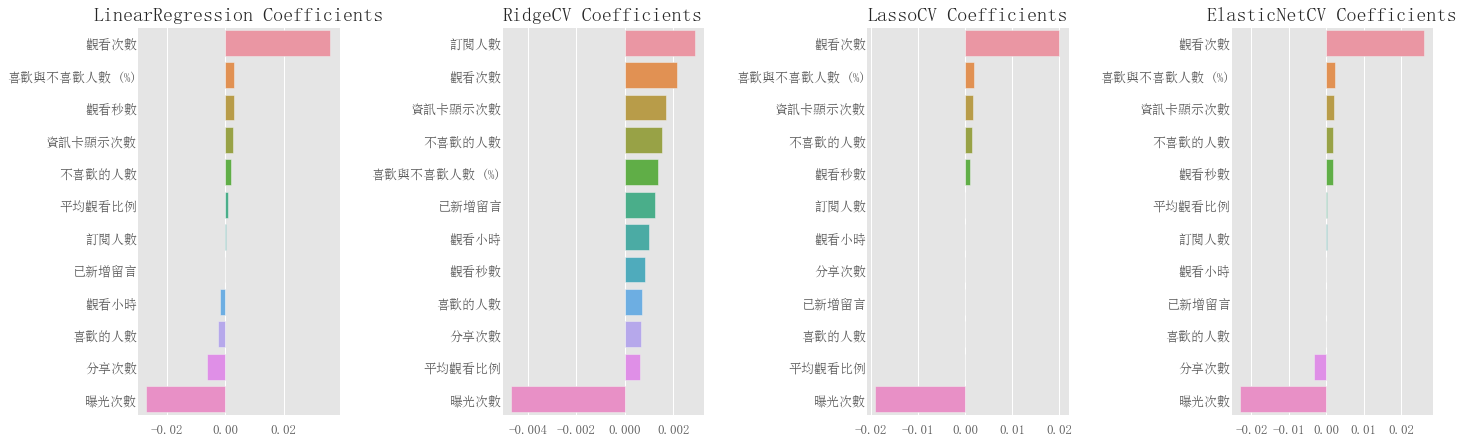

In [48]:
def get_top_bottom_coef(model):
    coef = pd.Series(model.coef_, index=X_train.columns).sort_values(ascending=False)
    return coef

def visualize_coefficient(models):
    fig, axs = plt.subplots(figsize=(20, 6), nrows=1, ncols=4)
    fig.tight_layout()
    
    for i_num, model in enumerate(models):
        coef = get_top_bottom_coef(model)
        axs[i_num].set_title(model.__class__.__name__+ ' Coefficients', size=20)
        axs[i_num].tick_params(axis='y', direction='in', pad=0)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(13)
        sns.barplot(x=coef.values,
                   y=coef.index, ax=axs[i_num])
        plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1, 
                    top=1, 
                    wspace=0.8, 
                    hspace=0.4)

lin = tt_lin.regressor_.named_steps['linearregression']
ridge = tt_ridge.regressor_.named_steps['ridgecv']
lasso = tt_lasso.regressor_.named_steps['lassocv']
elnet = tt_elnet.regressor_.named_steps['elasticnetcv']
models = [lin, ridge, lasso, elnet]

visualize_coefficient(models)

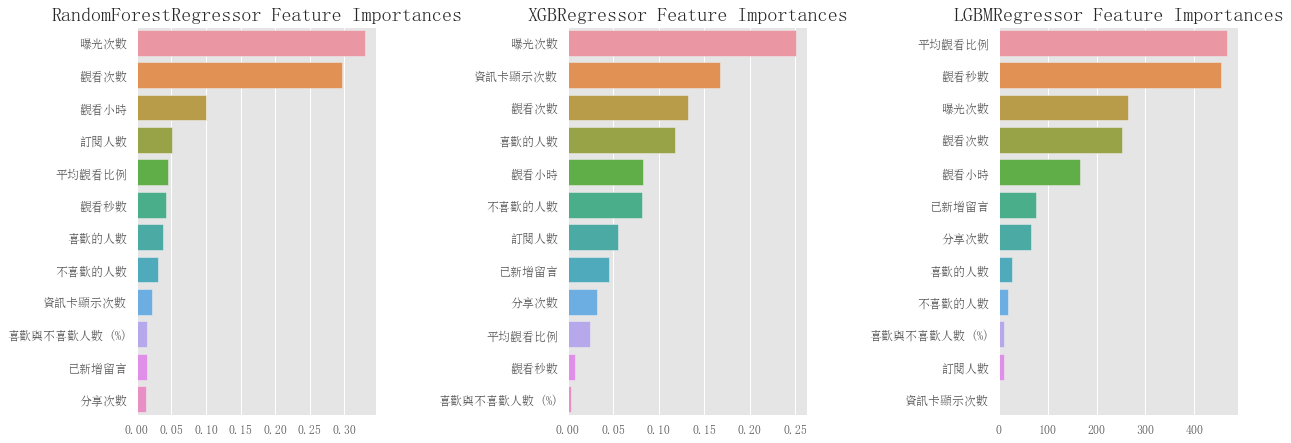

In [49]:
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns  )
    ftr_top = ftr_importances.sort_values(ascending=False)
    return ftr_top

def visualize_ftr_importances(models):
    fig, axs = plt.subplots(figsize=(17,6), nrows=1, ncols=3)
    fig.tight_layout() 
    for i_num, model in enumerate(models):
        ftr_top = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=20)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(12)
        sns.barplot(x=ftr_top.values, y=ftr_top.index , ax=axs[i_num])
        plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1, 
                    top=1, 
                    wspace=0.8, 
                    hspace=0.4)

rf = tt_rfreg.regressor_.named_steps['randomforestregressor']
xgb = tt_xgb.regressor_.named_steps['xgbregressor']
lgbm = tt_lgb.regressor_.named_steps['lgbmregressor']

models = [rf, xgb, lgbm]
visualize_ftr_importances(models)

In [50]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

rf_reg = RandomForestRegressor(
                               n_jobs=-1,
                               random_state=33)
# rf_reg = RandomForestRegressor(n_estimators=100,
#                                n_jobs=-1,
#                                random_state=33)

xgb_reg = XGBRegressor(
                       n_jobs=-1,
                       random_state=33,
                       seed=33)

lgb_reg = LGBMRegressor(n_estimators=100,
                        n_jobs=-1,
                        verbose=-1, 
                        random_state=33)

def randcv(estimator, params): #只挑其中幾個參數跑
    randcv = RandomizedSearchCV(estimator=estimator,
                                param_distributions=params,
                                n_iter=5,
                                scoring='neg_root_mean_squared_error',
                                cv=3,
                                random_state=33,
                                n_jobs=-1)

    tt = TransformedTargetRegressor(regressor=randcv,
                                func=np.log1p, inverse_func=np.expm1)

    tt.fit(X_train, y_train)
    y_pred = tt.predict(X_test)

    print('Best Params: ', tt.regressor_.best_params_)
    evaluate(estimator.__class__.__name__, y_test, y_pred)

    return tt.regressor_.best_estimator_

def gridcv(estimator, params): #給定的參數全部都跑過
    gridcv = GridSearchCV(
                            estimator=estimator,
                          param_grid=params,
                          scoring='neg_root_mean_squared_error',
                          cv=3,
                          n_jobs=-1)

    tt = TransformedTargetRegressor(regressor=gridcv,
                                func=np.log1p, inverse_func=np.expm1)

    tt.fit(X_train, y_train)
    y_pred = tt.predict(X_test)

    print('Best Params: ', tt.regressor_.best_params_)
    evaluate(estimator.__class__.__name__, y_test, y_pred)
    
    return tt.regressor_.best_estimator_

def createList(r1, r2):
    	return [item for item in range(r1, r2+1)]

params_rf = {'n_estimators': [91],
              'max_depth': [11], 
             'min_samples_split': [3], 
            #  'min_samples_leaf': createList(4,20)
             }


# randcv_rf = randcv(rf_reg, params_rf)
gridcv_rf = gridcv(rf_reg, params_rf)

Best Params:  {'max_depth': 11, 'min_samples_split': 3, 'n_estimators': 91}
*RandomForestRegressor Result*
RMSE Score:  0.013
R2 Score:  0.285


In [51]:
pipe_rfreg = make_pipeline(
    # StandardScaler(),
    RandomForestRegressor(n_estimators=91,
                          min_samples_split=3,
                        #   min_samples_leaf=1,
                          max_depth=11, 
                          n_jobs=-1,
                          oob_score=True, 
                          random_state=33)
)
#     RandomForestRegressor(n_estimators=16,
#                           min_samples_split=6,
#                           min_samples_leaf=5,
#                           max_depth=21, 
#                           n_jobs=-1,
#                           oob_score=True, 
#                           random_state=33)
# )

tt_rfreg = TransformedTargetRegressor(regressor=pipe_rfreg,
                                func=np.log1p, inverse_func=np.expm1)

tt_rfreg.fit(X_train, y_train)
y_pred = tt_rfreg.predict(X_test)
print('OOB Score: ', tt_rfreg.regressor_.named_steps['randomforestregressor'].oob_score_)
print('='*50)
evaluate('Log Transformed RandomForest Regressor for Training Set', y_train, tt_rfreg.predict(X_train))
evaluate('Log Transformed RandomForest Regressor for Test Set', y_test, y_pred)

OOB Score:  0.5069285957824056
*Log Transformed RandomForest Regressor for Training Set Result*
RMSE Score:  0.007
R2 Score:  0.92
*Log Transformed RandomForest Regressor for Test Set Result*
RMSE Score:  0.013
R2 Score:  0.285


In [52]:
y_pred

array([0.05389023, 0.07166759, 0.05436971, 0.0391944 , 0.0452365 ,
       0.05037198, 0.04992789, 0.05848662, 0.04081699, 0.03942192,
       0.03205114, 0.04635288, 0.04183549, 0.04209886, 0.04615282,
       0.06089469, 0.04371003, 0.04462482, 0.05003144, 0.05253375,
       0.07400477, 0.0426562 , 0.05249198, 0.0591531 , 0.04135246,
       0.04325134, 0.04944202, 0.05114864, 0.03892141, 0.04596433])

In [53]:
# params_xgb = {'n_estimators':[100],
#               'max_depth':[3], 
#               'learning_rate':[0.001, 0.01, 0.1, 0.15], 
#             }
params_xgb = {'n_estimators':[56],
              'max_depth':[3], 
              # 'learning_rate':[schedule(200)], 
              # 'learning_rate':[0.15], 
              # 'learning_rate':[0.001, 0.01, 0.1, 0.15,0.2,0.25,0.3,0.4], 
            }

# randcv(xgb_reg, params_xgb)
gridcv(xgb_reg, params_xgb)

Best Params:  {'max_depth': 3, 'n_estimators': 56}
*XGBRegressor Result*
RMSE Score:  0.01
R2 Score:  0.599


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=56, n_jobs=-1, num_parallel_tree=None, predictor=None,
             random_state=33, ...)

In [54]:
xgb_reg = XGBRegressor(n_estimators=56,
                #        learning_rate=0.15,
                       max_depth=3,
                       n_jobs=-1,
                       random_state=33,
                       seed=33)

tt_xgb = TransformedTargetRegressor(regressor=xgb_reg,
                                func=np.log1p, inverse_func=np.expm1)

tt_xgb.fit(X_train, y_train,
        verbose=False,
        early_stopping_rounds=100,
        eval_set=[(X_test, y_test)],
        eval_metric='rmse')
y_pred = tt_xgb.predict(X_test)
evaluate('Log Transformed XGB Regressor for Training Set', y_train, tt_xgb.predict(X_train))
evaluate('Log Transformed XGB Regressor for Test Set', y_test, y_pred)

*Log Transformed XGB Regressor for Training Set Result*
RMSE Score:  0.002
R2 Score:  0.993
*Log Transformed XGB Regressor for Test Set Result*
RMSE Score:  0.01
R2 Score:  0.602


In [55]:
y_pred

array([0.052439  , 0.07089661, 0.05445329, 0.03834396, 0.04085106,
       0.04244392, 0.02484671, 0.051712  , 0.04119315, 0.03999611,
       0.03057724, 0.04812769, 0.01954559, 0.04826505, 0.05099685,
       0.043736  , 0.03933761, 0.04350172, 0.0579927 , 0.05216009,
       0.08393972, 0.03894319, 0.04792492, 0.06526461, 0.03807138,
       0.04722506, 0.04547666, 0.04117244, 0.02328018, 0.046778  ],
      dtype=float32)

In [56]:
y_true = y_test.reset_index().copy()
y_true['y_pred'] = y_pred
y_true=y_true.reset_index(drop=1)
y_true

,index,曝光點閱率,y_pred
0,47,0.05,0.05
1,38,0.06,0.07
2,71,0.04,0.05
3,117,0.03,0.04
4,146,0.01,0.04
5,109,0.03,0.04
6,142,0.02,0.02
7,49,0.05,0.05
8,108,0.03,0.04
9,120,0.03,0.04


 <a name="PLOT"></a>
## PLOT

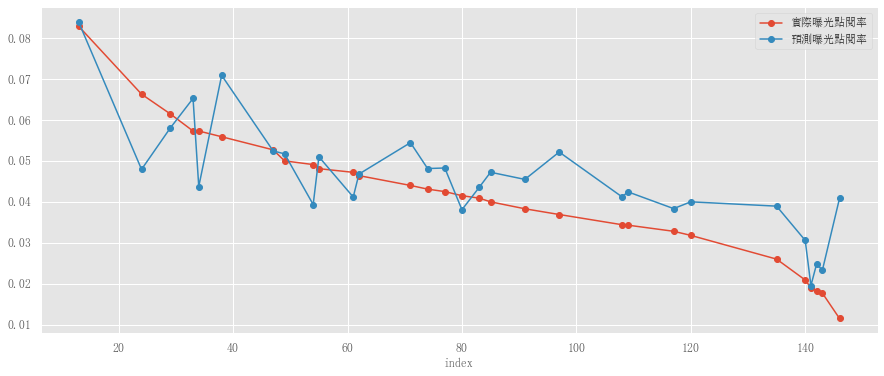

In [57]:


# plt.figure(figsize=(20, 6))
# sns.lineplot(data=y_true, x=y_true.index, y='曝光點閱率')
# sns.lineplot(data=y_true, x=y_true.index, y='y_pred')

# y_true.index=y_true.index.astype(str)
y_true=y_true.sort_values('index')
y_true=y_true.rename(columns={'曝光點閱率':'實際曝光點閱率','y_pred':'預測曝光點閱率'})
ax=y_true.plot('index',['實際曝光點閱率','預測曝光點閱率'],figsize=(15,6),marker='o',fontsize=12)
# ax.set_ylabel("訪視後增加回領率",fontsize=12) 
# plt.axhline(df.曝光點閱率.mean(), color='c', linestyle='--', linewidth=2)
# plt.annotate('平均曝光點閱率 {}'.format(round(df.曝光點閱率.mean(),4)), 
#              (df.date[20], 30), 
#              fontsize=12, 
#              color='c')
# plt.title('YouTube每日曝光點閱率', fontsize=20)
# plt.ylabel('曝光點閱率')
plt.show()

In [58]:
y_true #index 103

,index,實際曝光點閱率,預測曝光點閱率
20,13,0.08,0.08
22,24,0.07,0.05
18,29,0.06,0.06
23,33,0.06,0.07
15,34,0.06,0.04
1,38,0.06,0.07
0,47,0.05,0.05
7,49,0.05,0.05
16,54,0.05,0.04
14,55,0.05,0.05


In [59]:
params_lgb = {
              'num_leaves':[29], 
              'max_depth':[-1], 
              'learning_rate':[0.1],
              }

# randcv(lgb_reg, params_lgb)
gridcv(lgb_reg, params_lgb)

Best Params:  {'learning_rate': 0.1, 'max_depth': -1, 'num_leaves': 29}
*LGBMRegressor Result*
RMSE Score:  0.016
R2 Score:  -0.074


LGBMRegressor(n_jobs=-1, num_leaves=29, random_state=33, verbose=-1)

In [60]:
lgb_reg = LGBMRegressor(n_estimators=1000,
                        num_leaves=11,
                        max_depth=-1,
                        learning_rate=0.271,
                        reg_alpha=0.0003,
                        reg_lambda=1.2,
                        n_jobs=-1,
                        objective='regression',
                        verbose=-1,
                        random_state=33)

tt_lgb = TransformedTargetRegressor(regressor=lgb_reg,
                                func=np.log1p, inverse_func=np.expm1)

tt_lgb.fit(X_train, y_train,
        # verbose=False,
        # early_stopping_rounds=100,
        eval_set=[(X_test, y_test)],
        eval_metric='rmse')
y_pred = tt_lgb.predict(X_test)
evaluate('Log Transformed Light GBM Regressor for Training Set', y_train, tt_lgb.predict(X_train))
evaluate('Log Transformed Light GBM Regressor for Test Set', y_test, y_pred)

*Log Transformed Light GBM Regressor for Training Set Result*
RMSE Score:  0.002
R2 Score:  0.991
*Log Transformed Light GBM Regressor for Test Set Result*
RMSE Score:  0.02
R2 Score:  -0.708


In [61]:
y_pred = tt_rfreg.predict(X_test)*0.1 + tt_xgb.predict(X_test)*0.8 + tt_lgb.predict(X_test)*0.1
evaluate('[RF + XGB + LGBM]', y_test, y_pred)

*[RF + XGB + LGBM] Result*
RMSE Score:  0.01
R2 Score:  0.563


In [62]:
import eli5
from eli5.sklearn import PermutationImportance
from IPython.display import display
from matplotlib import colors

# Permutation Importance
def show_permutation_importance(model):
    prm_imps = PermutationImportance(model,
                                    scoring='neg_root_mean_squared_error',
                                    n_iter=5,
                                    random_state=33)

    prm_imps.fit(X_train, y_train)
    print('{} Permutation Importance'.format(model.__class__.__name__))
    # print(prm_imps)
    # print(eli5.show_weights(
    #     prm_imps,
    #     top=None,
    #     feature_names=X_train.columns.to_list()))
    display(eli5.show_weights(
        prm_imps,
        top=None,
        feature_names=X_train.columns.to_list(),include_styles=False
    ))
    eli5.show_weights(
        prm_imps,
        top=None,
        feature_names=X_train.columns.to_list())

    # print(prm_imps.feature_importances_)
    # print(prm_imps.scores_)
    # base_score, score_decreases = prm_imps.get_score_importances(score_func, X, y)
    # feature_importances = np.mean(score_decreases, axis=0)
    # plt.show()

show_permutation_importance(tt_rfreg)
show_permutation_importance(tt_xgb)
show_permutation_importance(tt_lgb)

TransformedTargetRegressor Permutation Importance


Weight,Feature
0.0199 ± 0.0016,曝光次數
0.0198 ± 0.0011,觀看次數
0.0039 ± 0.0004,觀看小時
0.0026 ± 0.0004,訂閱人數
0.0011 ± 0.0003,資訊卡顯示次數
0.0011 ± 0.0003,不喜歡的人數
0.0008 ± 0.0003,觀看秒數
0.0008 ± 0.0003,平均觀看比例
0.0008 ± 0.0002,喜歡的人數
0.0006 ± 0.0002,喜歡與不喜歡人數 (%)


TransformedTargetRegressor Permutation Importance


Weight,Feature
0.0398 ± 0.0018,曝光次數
0.0325 ± 0.0005,觀看次數
0.0104 ± 0.0012,觀看小時
0.0036 ± 0.0009,不喜歡的人數
0.0028 ± 0.0005,訂閱人數
0.0020 ± 0.0002,資訊卡顯示次數
0.0015 ± 0.0004,平均觀看比例
0.0009 ± 0.0002,觀看秒數
0.0008 ± 0.0003,喜歡的人數
0.0005 ± 0.0002,分享次數


TransformedTargetRegressor Permutation Importance


Weight,Feature
0.0343 ± 0.0026,觀看次數
0.0326 ± 0.0029,曝光次數
0.0117 ± 0.0016,平均觀看比例
0.0106 ± 0.0012,觀看秒數
0.0067 ± 0.0013,觀看小時
0.0019 ± 0.0003,訂閱人數
0.0016 ± 0.0006,分享次數
0.0014 ± 0.0002,已新增留言
0.0007 ± 0.0002,喜歡的人數
0.0006 ± 0.0001,喜歡與不喜歡人數 (%)


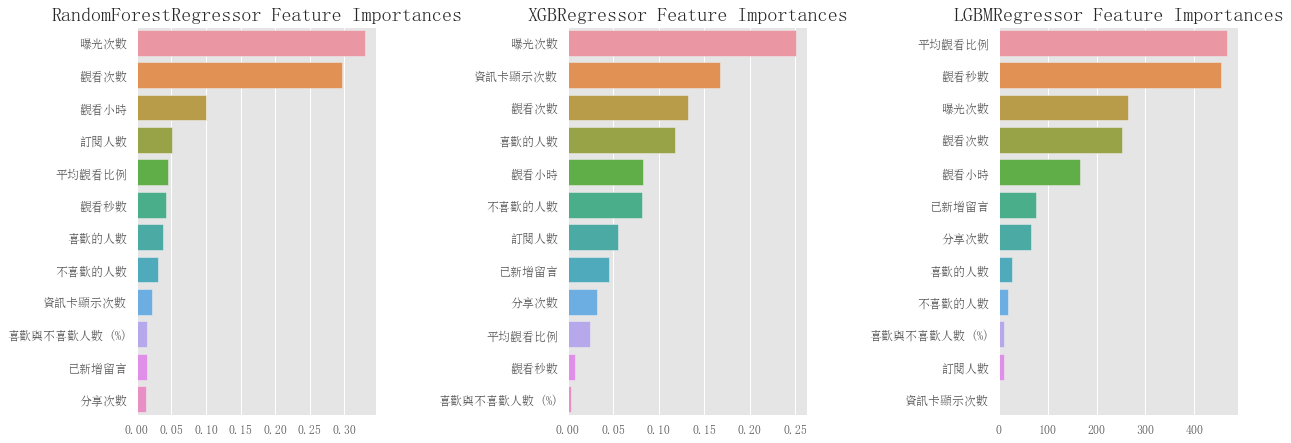

In [63]:
models = [rf, xgb, lgbm]
visualize_ftr_importances(models)

In [64]:
# from pdpbox.pdp import pdp_isolate, pdp_plot
# from pdpbox.pdp import pdp_interact, pdp_interact_plot
# from pdpbox import pdp
import shap

In [65]:
# def draw_pdp_plot(feature, model, X_val, num_grid_points = 10):
#     isolated = pdp_isolate(
#         model=model,
#         dataset=X_val,
#         model_features=X_val.columns,
#         feature=feature,
#         grid_type='percentile',
#         num_grid_points=num_grid_points
#     )
#     if model.regressor.__class__.__name__ == 'Pipeline':
#         print('<<<{} MODEL>>>'.format(model.regressor.named_steps['randomforestregressor'].__class__.__name__))
#     else:
#         print('<<<{} MODEL>>>'.format(model.regressor.__class__.__name__))
#     print('='*100)
#     pdp.pdp_plot(isolated, feature)

features = X_train.columns.tolist()[2:-1]
features

['觀看小時',
 '分享次數',
 '已新增留言',
 '喜歡的人數',
 '資訊卡顯示次數',
 '不喜歡的人數',
 '觀看秒數',
 '喜歡與不喜歡人數 (%)',
 '平均觀看比例']

In [66]:
X = pd.concat((X_train, X_test))

# def draw_pdp_interaction(model, features, X_test, plot_type):
#     interaction = pdp_interact(
#         model=model, 
#         dataset=X_test,
#         model_features=X_test.columns, 
#         features=features
#     )
#     if model.regressor.__class__.__name__ == 'Pipeline':
#         print('<<<{} MODEL>>>'.format(model.regressor.named_steps['randomforestregressor'].__class__.__name__))
#     else:
#         print('<<<{} MODEL>>>'.format(model.regressor.__class__.__name__))
#     print('='*100)
#     pdp_interact_plot(interaction, plot_type=plot_type, feature_names=features)
#     plt.show()

# features = ['喜歡的人數s', 'Watch_hours']
# draw_pdp_interaction(tt_xgb, features, X, 'contour')
# draw_pdp_interaction(tt_rfreg, features, X, 'contour')
# draw_pdp_interaction(tt_lgb, features, X, 'contour')

In [67]:
import matplotlib

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X)
shap.initjs()
p = shap.force_plot(explainer.expected_value, shap_values, X, plot_cmap = 'PkYg')
shap.save_html('./test.html', p)

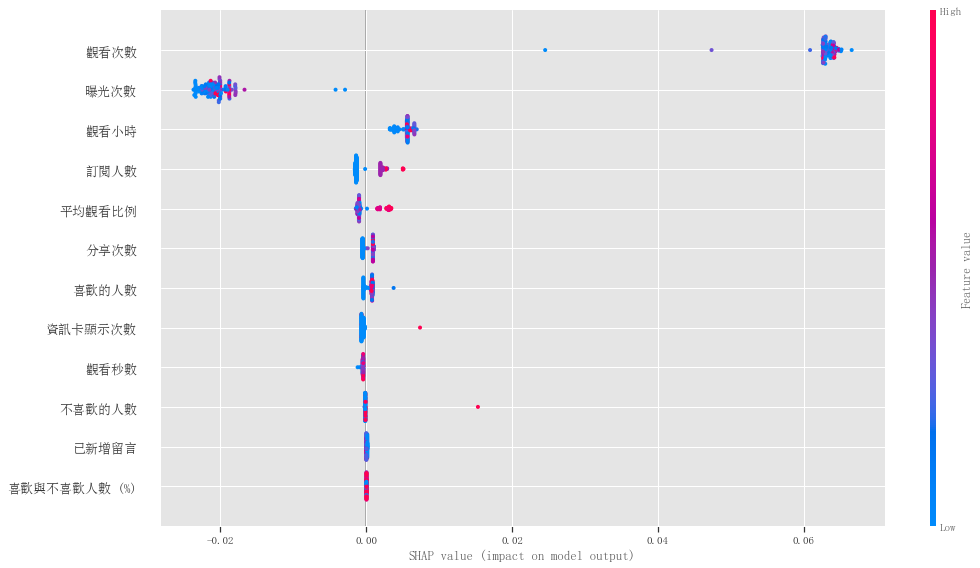

In [68]:
shap.summary_plot(shap_values, X, plot_size=(15,8))

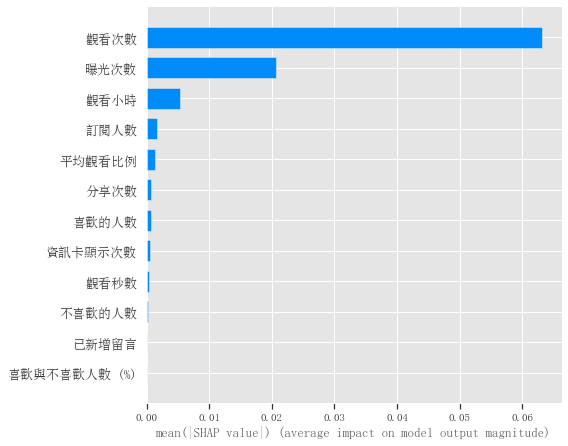

In [69]:
shap.summary_plot(shap_values, X, plot_type='bar')

In [70]:
def draw_shap_value(sample):
    explainer = shap.TreeExplainer(xgb)
    shap.initjs()
    samp_d = pd.DataFrame(dict(zip(X_test.columns, np.array(sample).reshape(-1,1))))
    display(shap.force_plot(explainer.expected_value, explainer.shap_values(samp_d[:1]), samp_d[:]))
    y_pred = np.exp(xgb.predict(samp_d))[0]
    base_value = np.exp(explainer.expected_value)
    samp_d.loc[1] = explainer.shap_values(samp_d[:1])[0].tolist()
    samp_d.index = ['YouTuber\'s Info', 'SHAP values']
    display(samp_d.style.apply(lambda x: ['background: red' if v>0 else 'background: blue' for v in x], axis=0))
    print('平均每日曝光點閱率: {}'.format(base_value))
    print('預測每日曝光點閱率:  {}'.format(y_pred))
    
import random
# sample = [X_train.iloc[:, 0].mean(),
#           X_train.iloc[:, 1].mean(),
#           X_train.iloc[:, 2].mean(),
          
#           X_train.iloc[:, 3].mean(),
#           X_train.iloc[:, 4].mean(),
#           X_train.iloc[:, 5].mean(),
          
#           X_train.iloc[:, 6].mean(),
#           X_train.iloc[:, 7].mean(),
#           X_train.iloc[:, 8].mean(),
#           X_train.iloc[:, 9].mean(),
#           X_train.iloc[:, 10].mean(),
#           X_train.iloc[:, 11].mean(),
#           X_train.iloc[:, 12].mean(),
#           X_train.iloc[:, 13].mean(),
#           X_train.iloc[:, 14].mean(),
#           X_train.iloc[:, 15].mean()]

# sample = [X_train.iloc[1:2, 0],
#           X_train.iloc[1:2, 1],
#           X_train.iloc[1:2, 2],
          
#           X_train.iloc[1:2, 3],
#           X_train.iloc[1:2, 4],
#           X_train.iloc[1:2, 5],
          
#           X_train.iloc[1:2:, 6]]
sample = [X_train.iloc[:, 0],
          X_train.iloc[:, 1],
          X_train.iloc[:, 2],
          
          X_train.iloc[:, 3],
          X_train.iloc[:, 4],
          X_train.iloc[:, 5],
          
          X_train.iloc[:, 6]]
draw_shap_value(sample)


##
# sample = [round(random.uniform(10000,500000)),
#           round(random.uniform(100000,10226681)),
#           round(random.uniform(1000,40326)),
#           round(random.uniform(10000,503655)),
          
#           round(random.uniform(3000,40000), 4),
#           round(random.uniform(2000,500000)),
#           round(random.uniform(2000,500000)),
          
#           round(random.uniform(2000,500000)),
#           round(random.uniform(2000,500000)),
#           round(random.uniform(2000,500000))]


,觀看次數,訂閱人數,觀看小時,分享次數,已新增留言,喜歡的人數,資訊卡顯示次數,不喜歡的人數,觀看秒數,喜歡與不喜歡人數 (%),平均觀看比例,曝光次數
YouTuber's Info,453.000000,41.000000,88.000000,58.000000,76.000000,71.000000,71.000000,486.000000,753.000000,39.000000,30.000000,24.000000
SHAP values,0.046431,0.002418,0.007092,0.000914,0.000013,0.001978,0.003600,0.015311,-0.000457,0.000028,0.004151,-0.016711


平均每日曝光點閱率: 1.0487300157546997
預測每日曝光點閱率:  1.1189016103744507


In [71]:
X_train.iloc[:, 0]

0       453.00
1        41.00
2        88.00
3        58.00
4        76.00
        ...   
112     306.00
113     231.00
114     639.00
115     243.00
116   1,636.00
Name: 觀看次數, Length: 117, dtype: float64

In [72]:
explainer = shap.TreeExplainer(xgb)
shap.initjs()
samp_d = pd.DataFrame(dict(zip(X_test.columns, np.array(sample).reshape(-1,1))))
p = shap.force_plot(explainer.expected_value, shap_values, X, plot_cmap = 'PkYg')
shap.save_html('./test.html', p)
shap.force_plot(explainer.expected_value, shap_values, X)

In [73]:
explainer = shap.TreeExplainer(xgb)
shap.initjs()
# samp_d = pd.DataFrame(dict(zip(X_test.columns, np.array(sample).reshape(-1,1))))
samp_d = pd.DataFrame(dict(zip(X_test.columns, np.array(sample).reshape(-1,1))))
display(shap.force_plot(explainer.expected_value, explainer.shap_values(samp_d[:1]), samp_d[:]))

In [74]:
explainer.shap_values(samp_d[:1])

array([[ 4.64309976e-02,  2.41758372e-03,  7.09210848e-03,
         9.14198172e-04,  1.30516828e-05,  1.97816477e-03,
         3.59957735e-03,  1.53107075e-02, -4.57319024e-04,
         2.78513035e-05,  4.15124465e-03, -1.67105999e-02]], dtype=float32)

In [75]:
X_train.columns

Index(['觀看次數', '訂閱人數', '觀看小時', '分享次數', '已新增留言', '喜歡的人數', '資訊卡顯示次數', '不喜歡的人數',
       '觀看秒數', '喜歡與不喜歡人數 (%)', '平均觀看比例', '曝光次數'],
      dtype='object')

In [76]:
X_train.columns

Index(['觀看次數', '訂閱人數', '觀看小時', '分享次數', '已新增留言', '喜歡的人數', '資訊卡顯示次數', '不喜歡的人數',
       '觀看秒數', '喜歡與不喜歡人數 (%)', '平均觀看比例', '曝光次數'],
      dtype='object')

In [77]:

# def pred_觀看次數(觀看次數, 獲得的訂閱人數, 已新增留言, 分享次數, 觀看小時, 喜歡的人數, 曝光次數, 平均觀看比例):
#     YouTuber_info = [觀看次數, 獲得的訂閱人數, 已新增留言, 分享次數, 觀看小時, 喜歡的人數, 曝光次數, 平均觀看比例]
#     draw_shap_value(YouTuber_info)
    
# pred_觀看次數(287.5086206896552,
# 0.4224137931034483,
# 0.9741379310344828,
# 1.1896551724137931,
# 8.862068965517242,
# 1.8706896551724137,
# 7531.250590884212,
# 0.30706896551724144)
# # pred_觀看次數(57626.0, 2586855.0, 4954.0, 141204.0, 10312.5295, 253140.0)
# print('實際曝光點閱率:  {}'.format(y_test.iloc[0]))

In [78]:
df.to_excel('0.xlsx')